In [33]:
import numpy as np
import pandas as pd
import os
import re
import astropy.units as u
import sys
import multiprocessing as mp
import tqdm

import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='none')
rc('xtick', labelsize=50)
rc('ytick', labelsize=50)
mpl.rcParams['axes.linewidth'] = 2

import vplanet_inference as vpi
sys.path.append(os.path.realpath("../src"))

In [2]:
inpath = os.path.join(vpi.INFILE_DIR, "stellar_eqtide/ctl")

inparams = {
            "primary.dMass": u.Msun, 
            "secondary.dMass": u.Msun, 
            "primary.dRotPeriod": u.day, 
            "secondary.dRotPeriod": u.day, 
            "primary.dTidalTau": u.dex(u.s), 
            "secondary.dTidalTau": u.dex(u.s), 
            "secondary.dEcc": u.dimensionless_unscaled, 
            "secondary.dOrbPeriod": u.day,
            "vpl.dStopTime": u.Gyr
}

outparams = {
             "final.primary.RotPer": u.day, 
             "final.secondary.Eccentricity": u.dimensionless_unscaled,
             "final.secondary.OrbPeriod": u.day,
             "final.secondary.RotPer": u.day
}

ctl = vpi.VplanetModel(inparams, inpath=inpath, outparams=outparams, 
                       verbose=False, timesteps=1e6*u.yr, time_init=5e6*u.yr)

In [27]:
inpath = os.path.join(vpi.INFILE_DIR, "stellar_eqtide/cpl")

inparams = {
            "primary.dMass": u.Msun, 
            "secondary.dMass": u.Msun, 
            "primary.dRotPeriod": u.day, 
            "secondary.dRotPeriod": u.day, 
            "primary.dTidalQ": u.dex(u.s), 
            "secondary.dTidalQ": u.dex(u.s), 
            "secondary.dEcc": u.dimensionless_unscaled, 
            "secondary.dOrbPeriod": u.day,
            "vpl.dStopTime": u.Gyr
}

cpl = vpi.VplanetModel(inparams, inpath=inpath, outparams=outparams, 
                       verbose=False, timesteps=1e6*u.yr, time_init=5e6*u.yr)

In [3]:
tvals = np.round(np.arange(-4, 2, .4),1)

nsim = len(tvals)
mass1 = np.ones(nsim)
mass2 = np.ones(nsim)
prot1 = 0.5 * np.ones(nsim)
prot2 = 0.5 * np.ones(nsim)
porb = 7.0 * np.ones(nsim)
ecc = 0.2 * np.ones(nsim)
ages = 8 * np.ones(nsim)

theta_tau = np.array([mass1, mass2, prot1, prot2, tvals, tvals, ecc, porb, ages]).T

In [25]:
qvals = np.round(np.arange(4, 9, .4),1)

nsim = len(qvals)
mass1 = np.ones(nsim)
mass2 = np.ones(nsim)
prot1 = 0.5 * np.ones(nsim)
prot2 = 0.5 * np.ones(nsim)
porb = 7.0 * np.ones(nsim)
ecc = 0.2 * np.ones(nsim)
ages = 8 * np.ones(nsim)

theta_q = np.array([mass1, mass2, prot1, prot2, qvals, qvals, ecc, porb, ages]).T

In [4]:
def run_models(vpm, theta_var_array, ncore=4):
    with mp.Pool(ncore) as p:
        outputs = []
        for result in tqdm.tqdm(p.imap(func=vpm.run_model, iterable=theta_var_array), total=len(theta_var_array)):
            outputs.append(result)
        outputs = np.array(outputs)
    return outputs

In [5]:
ctl_evol = run_models(ctl, theta_tau, ncore=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [05:08<00:00, 20.57s/it]


In [28]:
cpl_evol = run_models(cpl, theta_q, ncore=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [03:50<00:00, 17.69s/it]


In [8]:
def plot_evolution_panel(sims, qplot, ls=50, lw=1.5, 
                         savename="evol_plot.png",
                         cb_label=r'$\log(\tau)$ [dex(s)]', 
                         cmap=mpl.cm.jet):
    
    results = [str(tv) for tv in qplot]
    
    c = np.arange(0, len(sims))
    norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cmap.set_array([])

    fig, axs = plt.subplots(1, 3, figsize=[40,15], sharex=True)
    fig.subplots_adjust(wspace=0.18)

    for ii in range(len(results)):

        axs[0].plot(sims[ii]['Time'], sims[ii]['final.secondary.OrbPeriod'], lw=lw, c=cmap.to_rgba(ii))
        axs[1].plot(sims[ii]['Time'], sims[ii]['final.secondary.RotPer'], lw=lw, c=cmap.to_rgba(ii))
        im = axs[2].plot(sims[ii]['Time'], sims[ii]['final.secondary.Eccentricity'], lw=lw, c=cmap.to_rgba(ii))

    plt.minorticks_on()
    cb = fig.colorbar(cmap, ticks=c, ax=axs, orientation='vertical', pad=.02)
    cb.set_label(cb_label, fontsize=ls)
    cb.ax.set_yticklabels(qplot)

    plt.xscale('log')
    plt.xlim(9e5, 8e9)
    axs[0].set_title("Orbital Period [d]", fontsize=ls)
    axs[1].set_title("Rotation Period [d]", fontsize=ls)
    axs[2].set_title("Eccentricity", fontsize=ls)
    axs[0].set_xlabel('Time [yr]', fontsize=ls)
    axs[1].set_xlabel('Time [yr]', fontsize=ls)
    axs[2].set_xlabel('Time [yr]', fontsize=ls)
    axs[0].minorticks_on()
    axs[1].minorticks_on()
    axs[2].minorticks_on()
    plt.savefig(savename, bbox_inches='tight', transparent=True)
    plt.show()

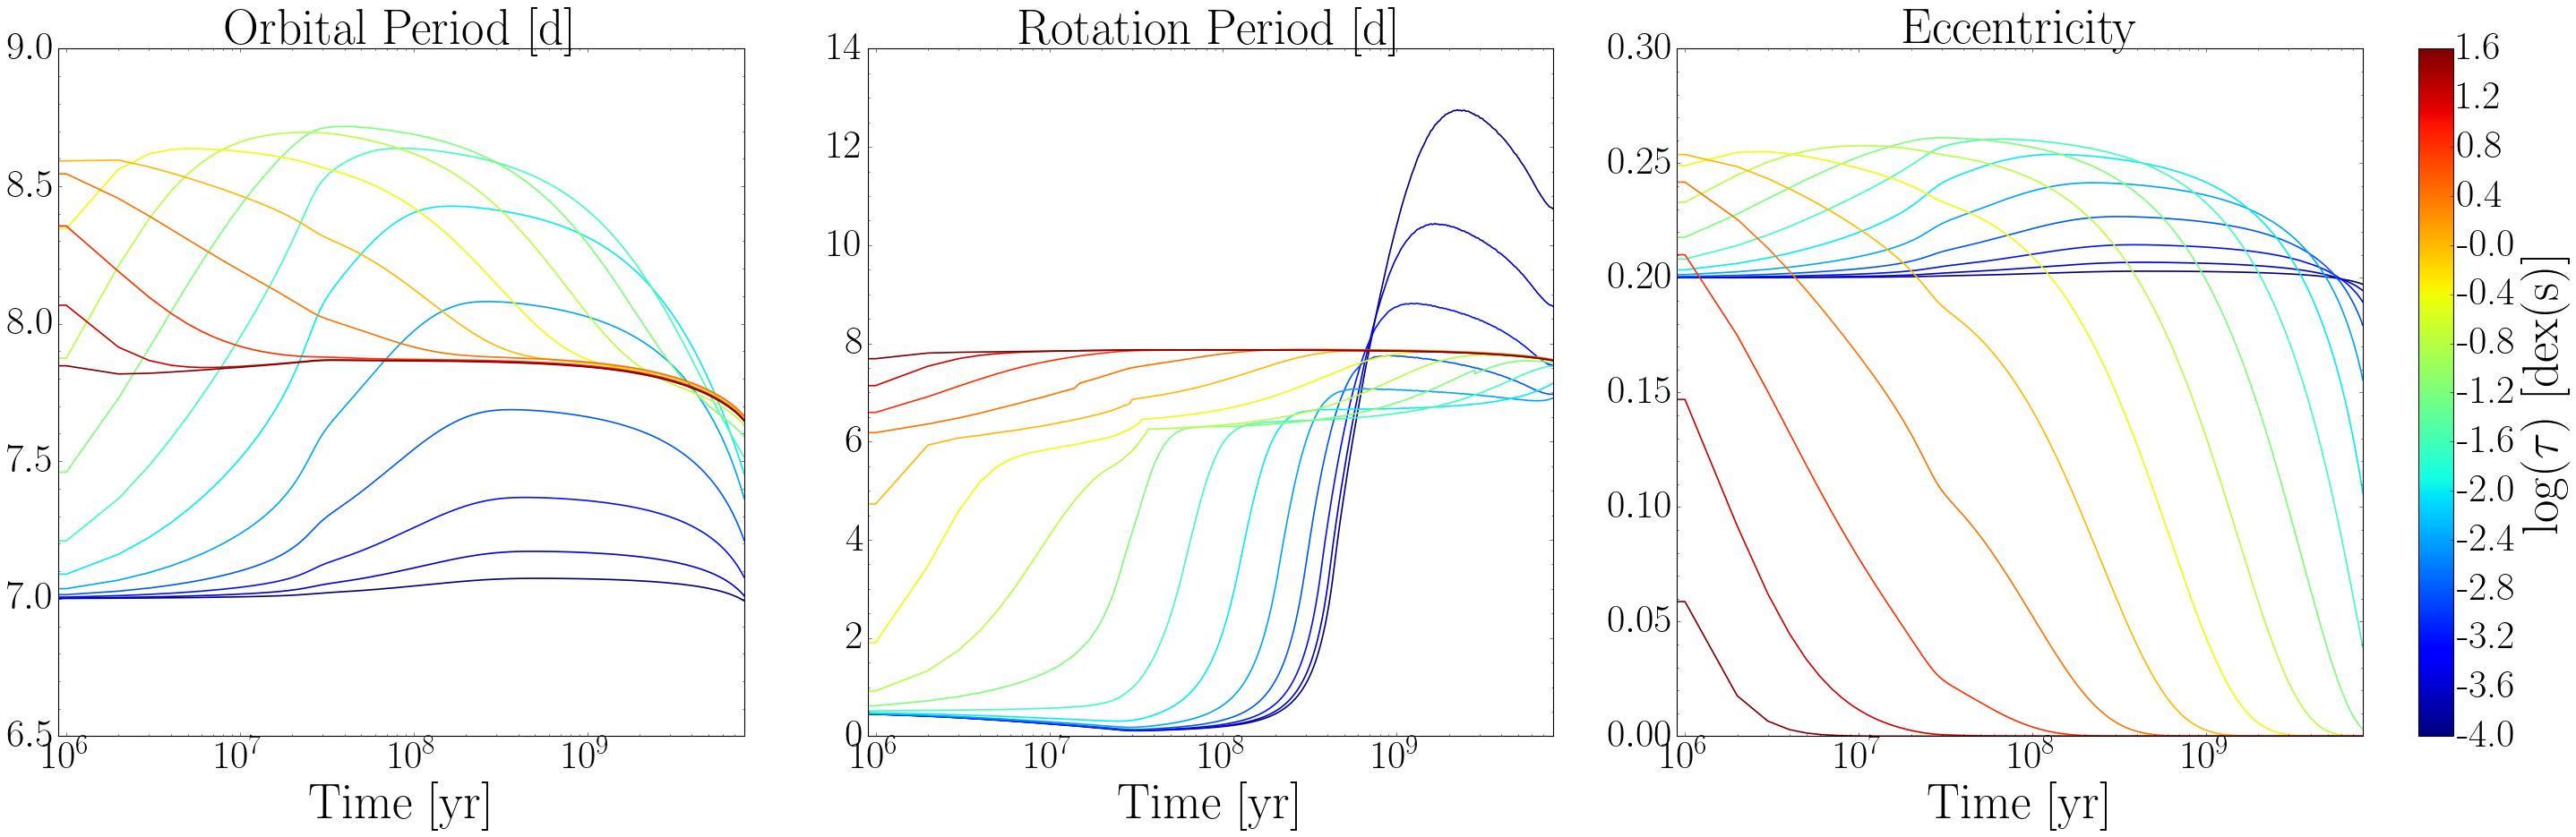

In [15]:
# sims = ctl_evol
# qplot = tvals
# plot_evolution_panel(ctl_evol, tvals, savename="../draft/figures/vary_tau_evolution.png", cb_label=r'$\log(\tau)$ [dex(s)]')
plot_evolution_panel(ctl_evol, tvals, savename="/home/jbirky/Dropbox/proposals/finnest23/vary_tau_evolution.png", cb_label=r'$\log(\tau)$ [dex(s)]')

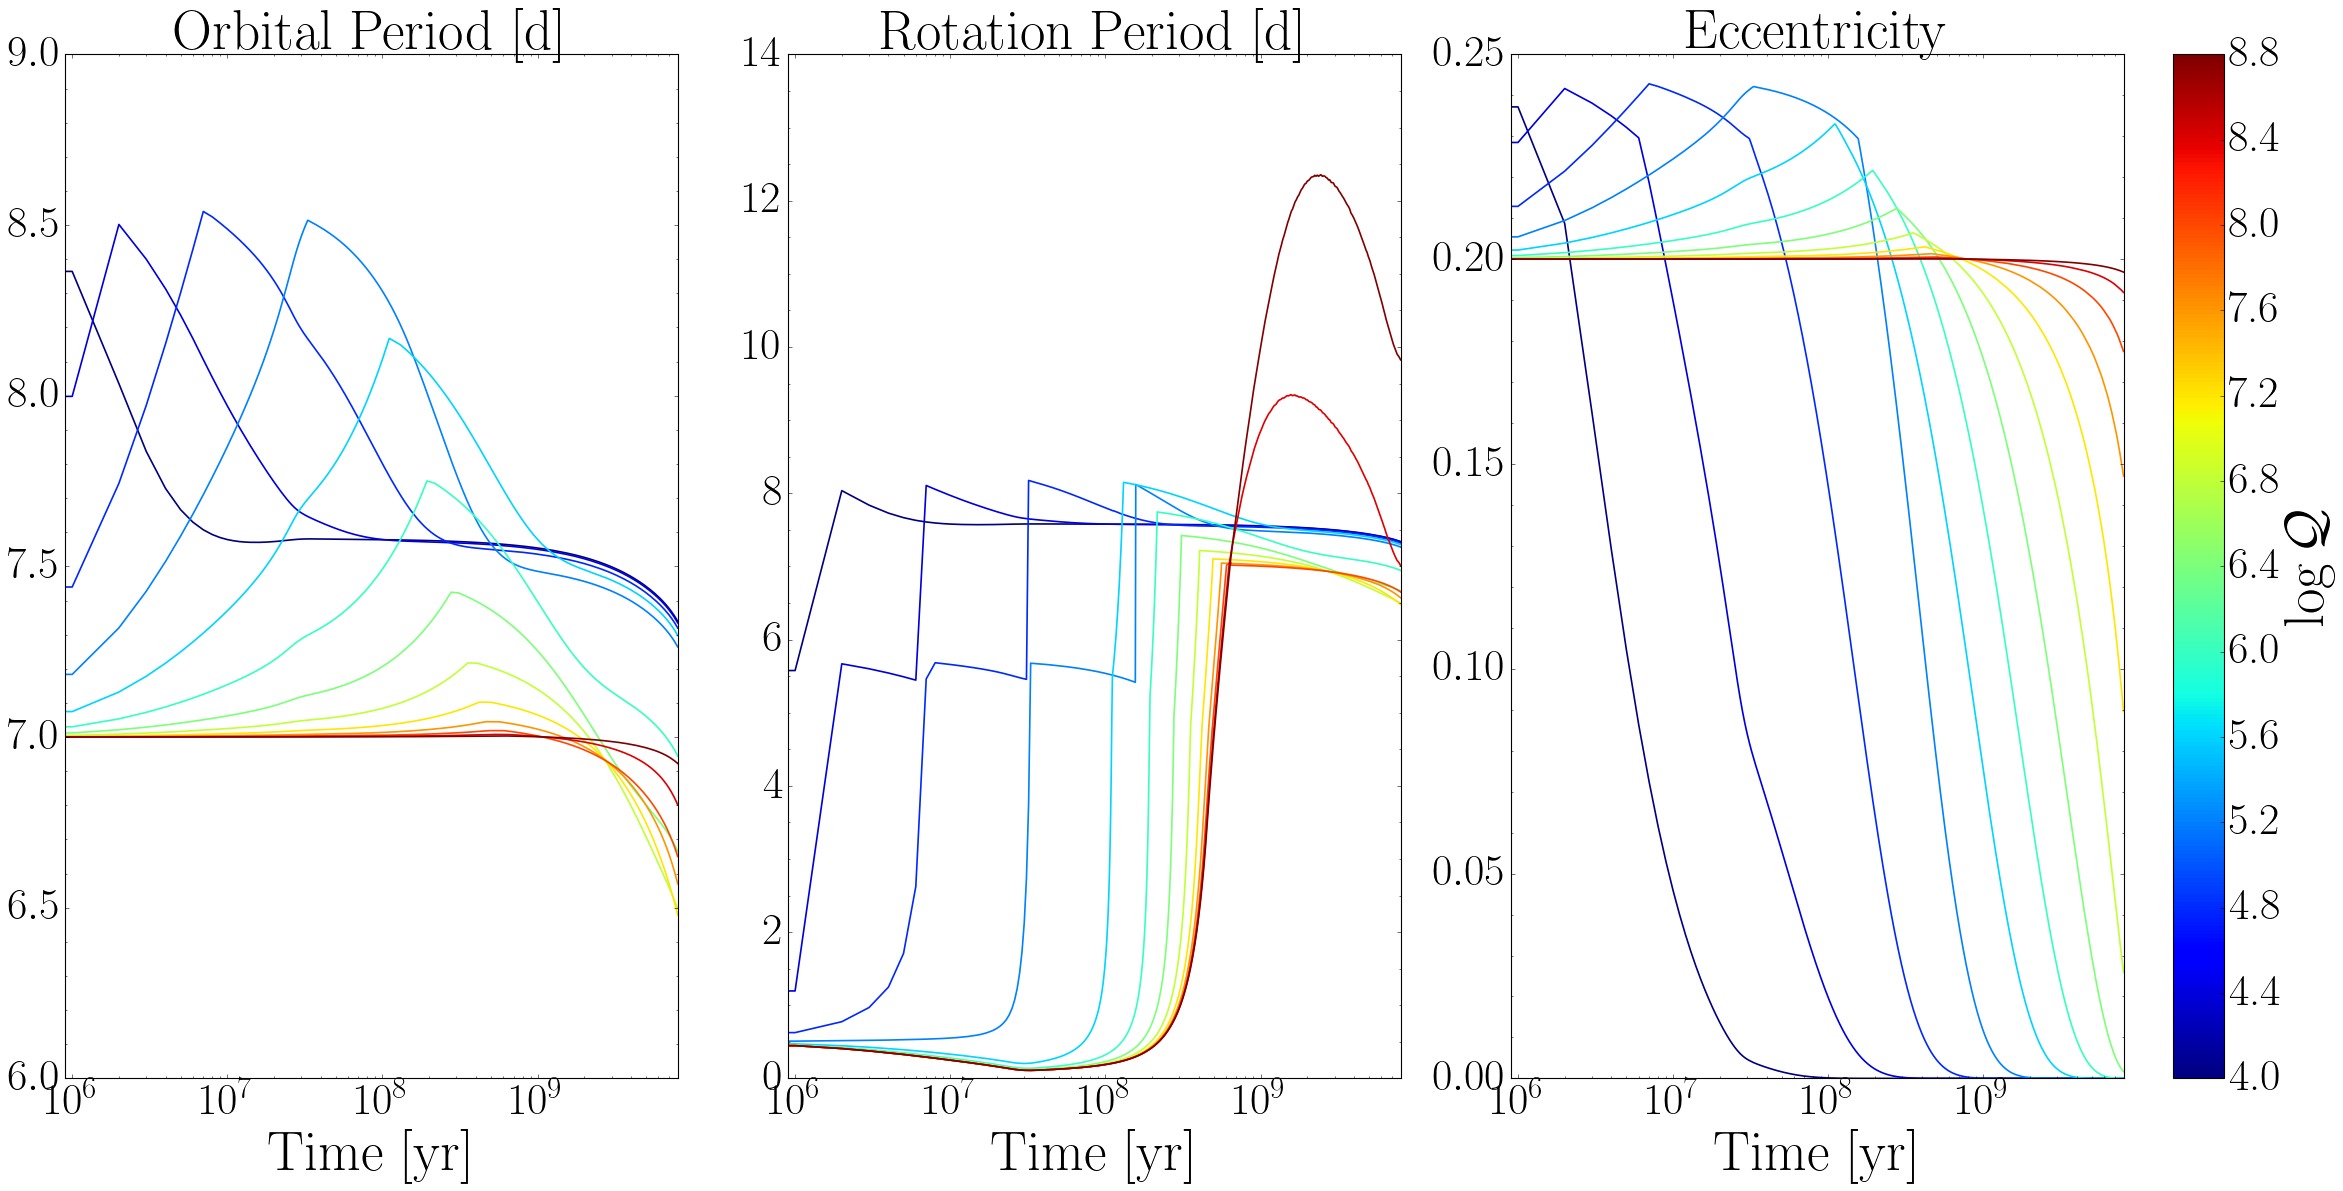

In [29]:
plot_evolution_panel(cpl_evol, qvals, savename="../draft/figures/vary_q_evolution.png", cb_label=r'$\log\mathcal{Q}$')

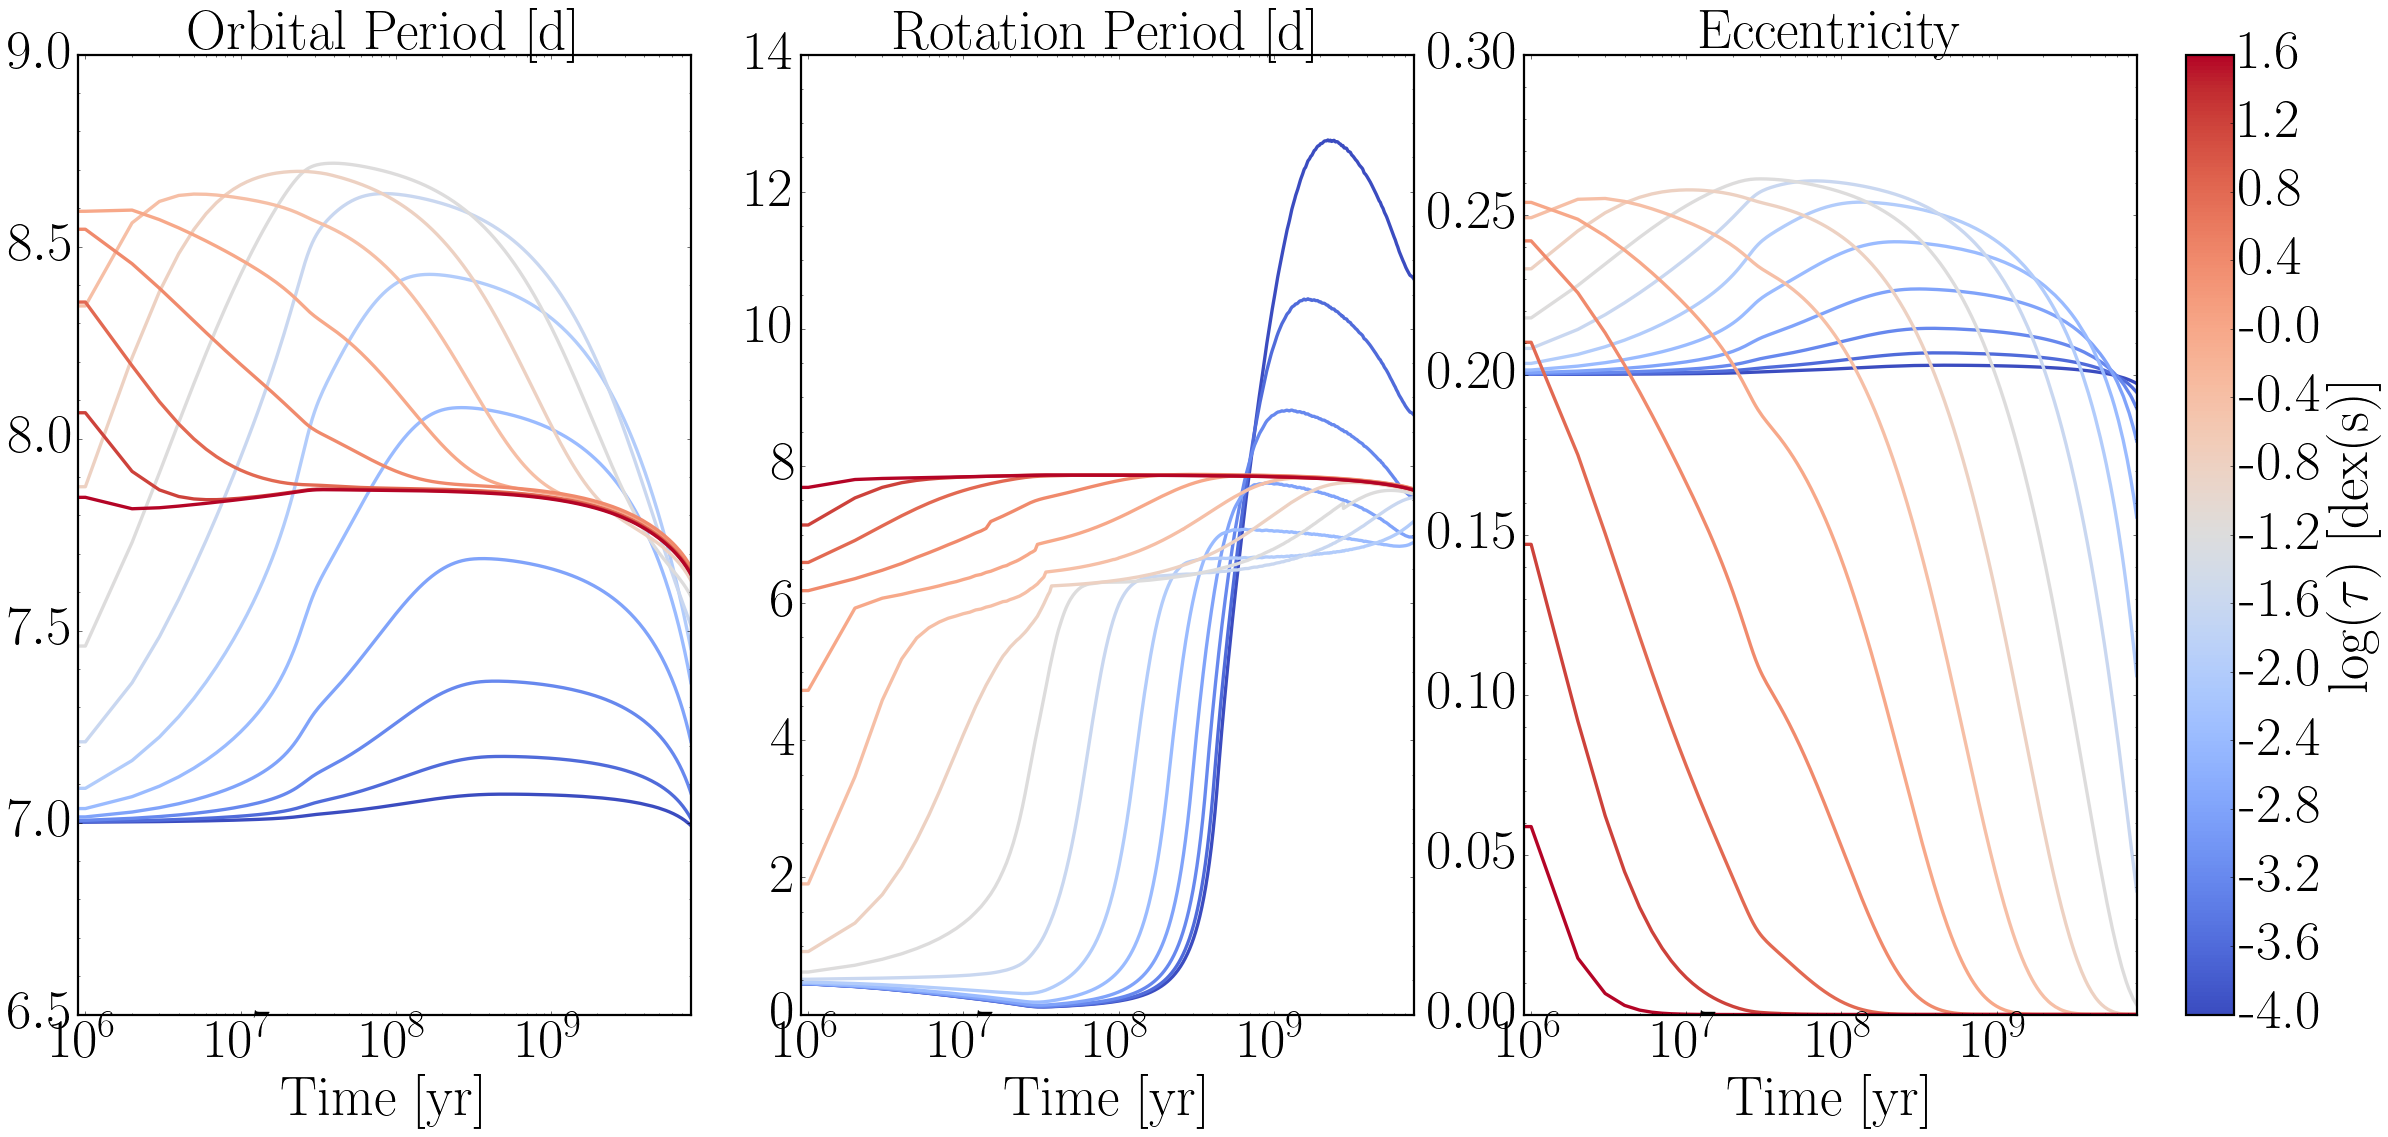

In [9]:
plot_evolution_panel(ctl_evol, tvals, savename="/home/jbirky/Dropbox/Apps/Overleaf/Binary_Tides/figures/vary_tau_evolution.png", 
                     cb_label=r'$\log(\tau)$ [dex(s)]', cmap=mpl.cm.coolwarm, lw=3)

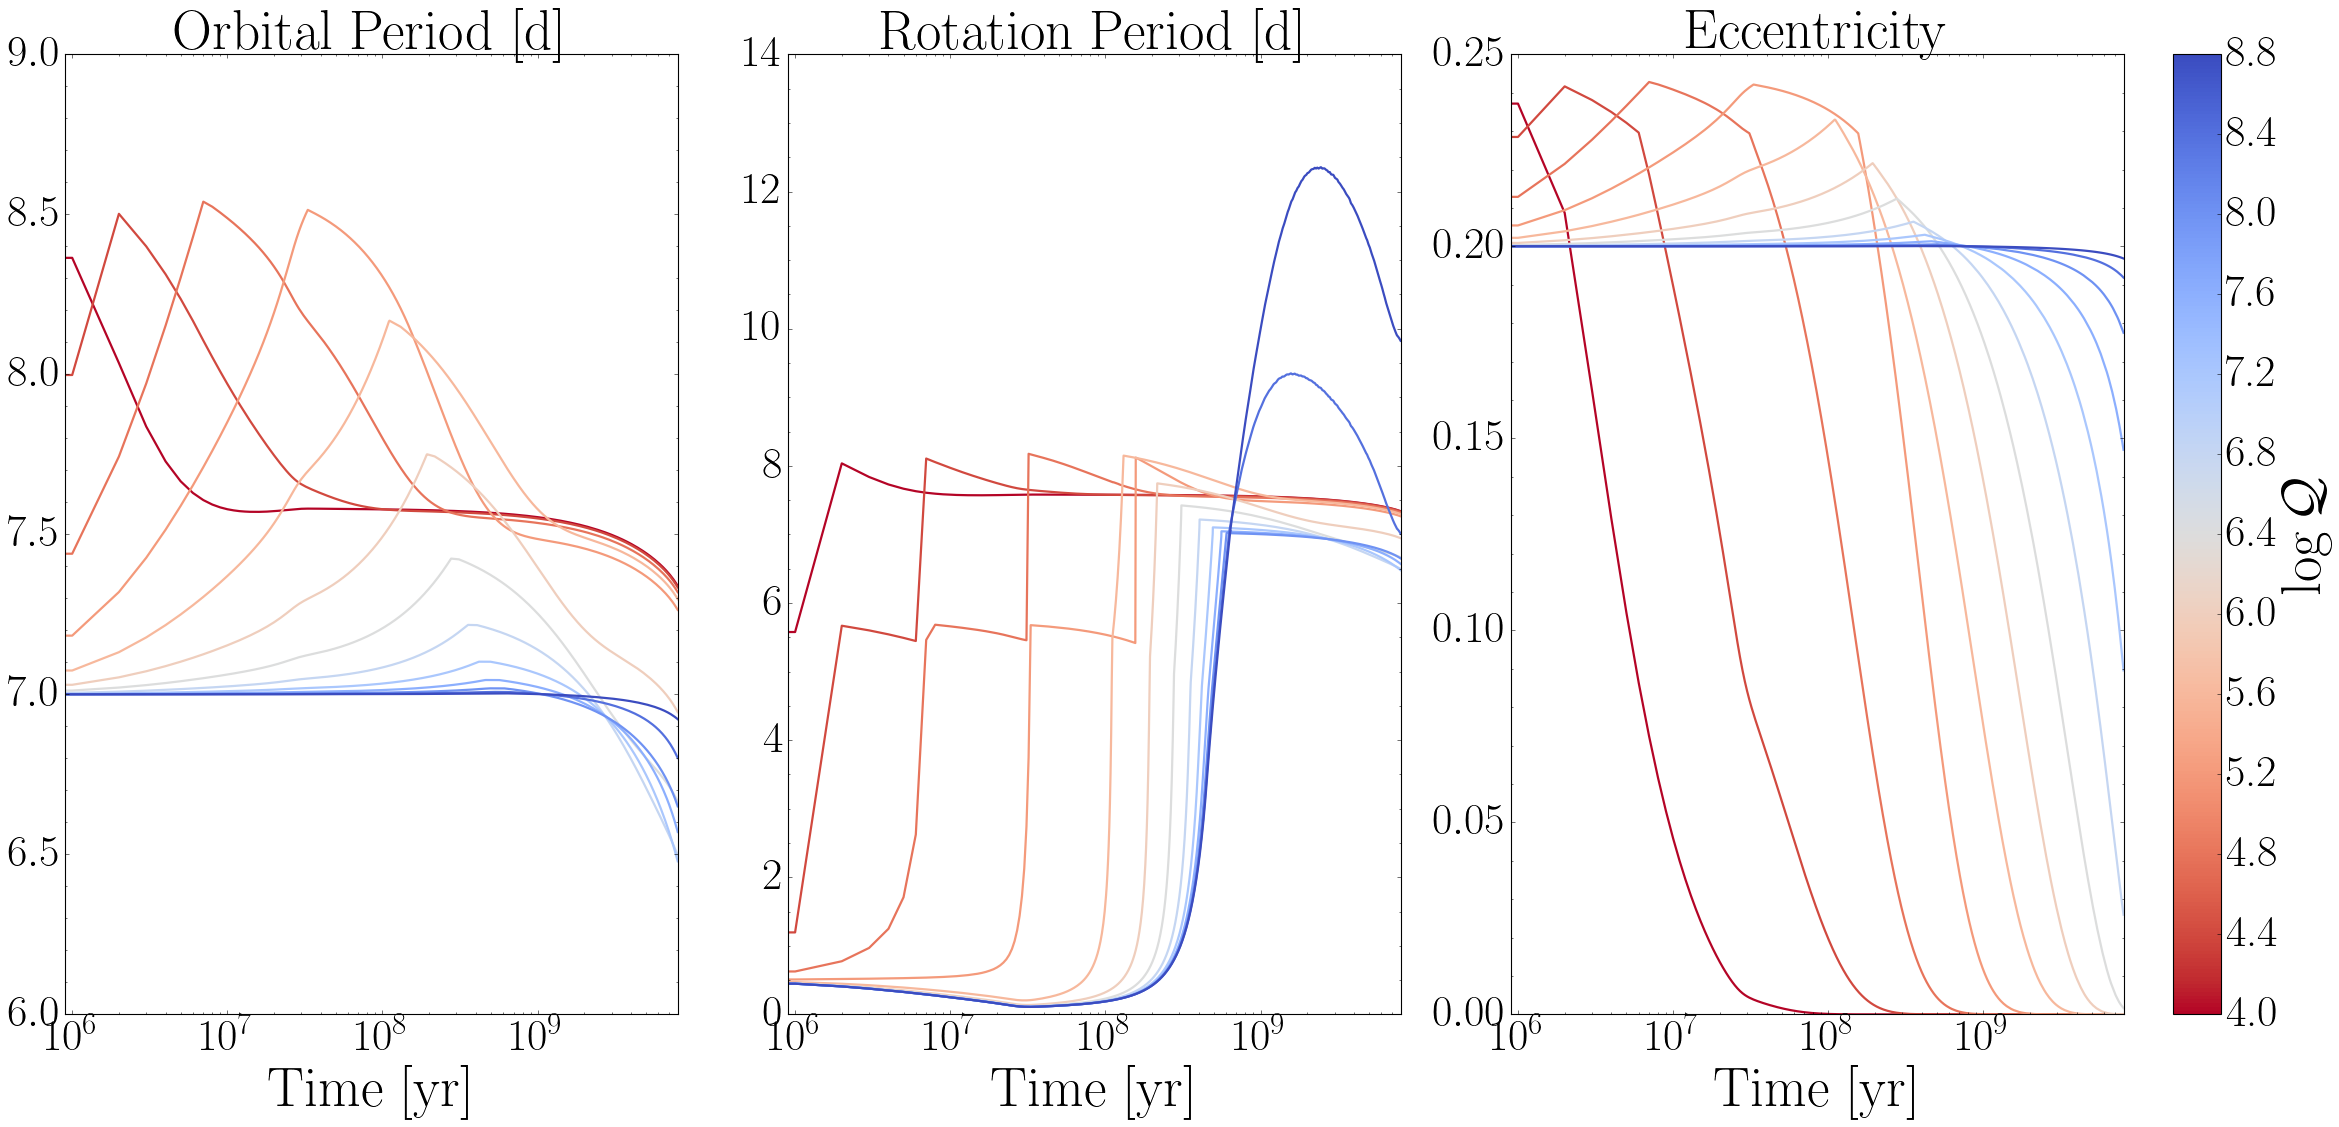

In [36]:
plot_evolution_panel(cpl_evol, qvals, savename="/home/jbirky/Dropbox/Apps/Overleaf/Binary_Tides/figures/vary_q_evolution.png", cb_label=r'$\log\mathcal{Q}$', cmap=mpl.cm.coolwarm_r, lw=2)

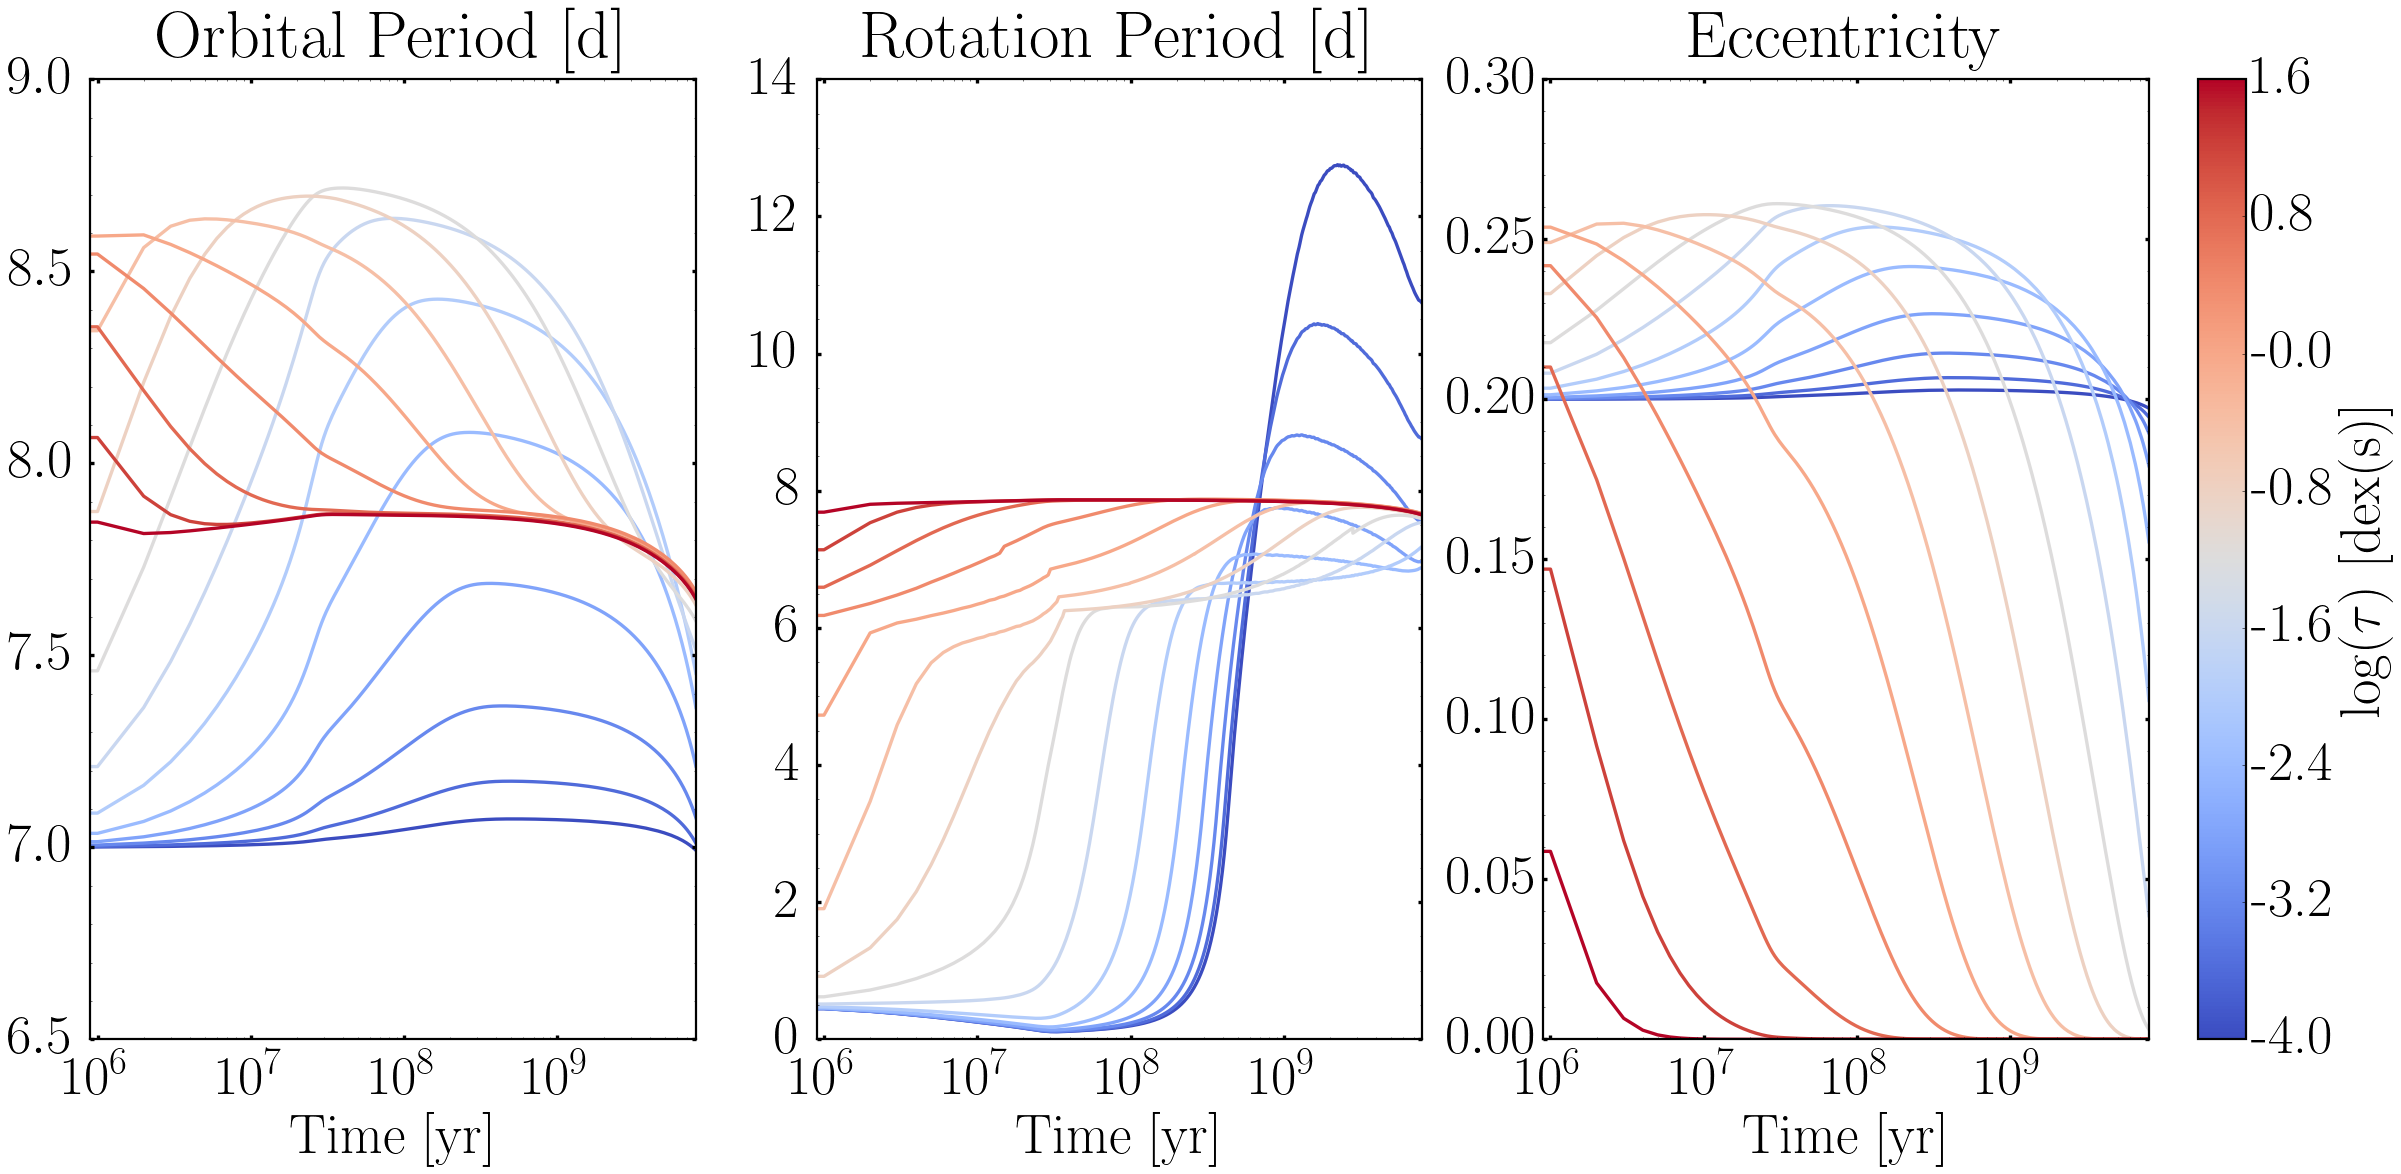

In [38]:
sims, qplot = ctl_evol, tvals
lw = 3
ls = 50
savename="/home/jbirky/Dropbox/Apps/Overleaf/Binary_Tides/figures/vary_tau_evolution.png"
cb_label=r'$\log(\tau)$ [dex(s)]'
cmap=mpl.cm.coolwarm

results = [str(tv) for tv in qplot]
    
c = np.arange(0, len(sims))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cmap.set_array([])

fig, axs = plt.subplots(1, 3, figsize=[40,15], sharex=True)
fig.subplots_adjust(wspace=0.20)

for ii in range(len(results)):

    axs[0].plot(sims[ii]['Time'], sims[ii]['final.secondary.OrbPeriod'], lw=lw, c=cmap.to_rgba(ii))
    axs[1].plot(sims[ii]['Time'], sims[ii]['final.secondary.RotPer'], lw=lw, c=cmap.to_rgba(ii))
    im = axs[2].plot(sims[ii]['Time'], sims[ii]['final.secondary.Eccentricity'], lw=lw, c=cmap.to_rgba(ii))

plt.minorticks_on()
cb = fig.colorbar(cmap, ticks=c, ax=axs, orientation='vertical', pad=.02)
cb.set_label(cb_label, fontsize=ls)
cb.ax.set_yticklabels(qplot)
cb.set_ticks(c[::2])
cb.set_ticklabels(results[::2])

plt.xscale('log')
plt.xlim(9e5, 8e9)
axs[0].set_title("Orbital Period [d]", fontsize=ls+10, pad=20)
axs[1].set_title("Rotation Period [d]", fontsize=ls+10, pad=20)
axs[2].set_title("Eccentricity", fontsize=ls+10, pad=20)
axs[0].set_xlabel('Time [yr]', fontsize=ls)
axs[1].set_xlabel('Time [yr]', fontsize=ls)
axs[2].set_xlabel('Time [yr]', fontsize=ls)
axs[0].minorticks_on()
axs[1].minorticks_on()
axs[2].minorticks_on()
axs[0].xaxis.set_tick_params(width=3)
axs[0].yaxis.set_tick_params(width=3)
axs[1].xaxis.set_tick_params(width=3)
axs[1].yaxis.set_tick_params(width=3)
axs[2].xaxis.set_tick_params(width=3)
axs[2].yaxis.set_tick_params(width=3)
axs[0].tick_params(axis='both', which='major', pad=15)
axs[1].tick_params(axis='both', which='major', pad=15)
axs[2].tick_params(axis='y', which='major', pad=5)
axs[2].tick_params(axis='x', which='major', pad=15)
plt.savefig(savename, bbox_inches='tight', transparent=True)
plt.show()

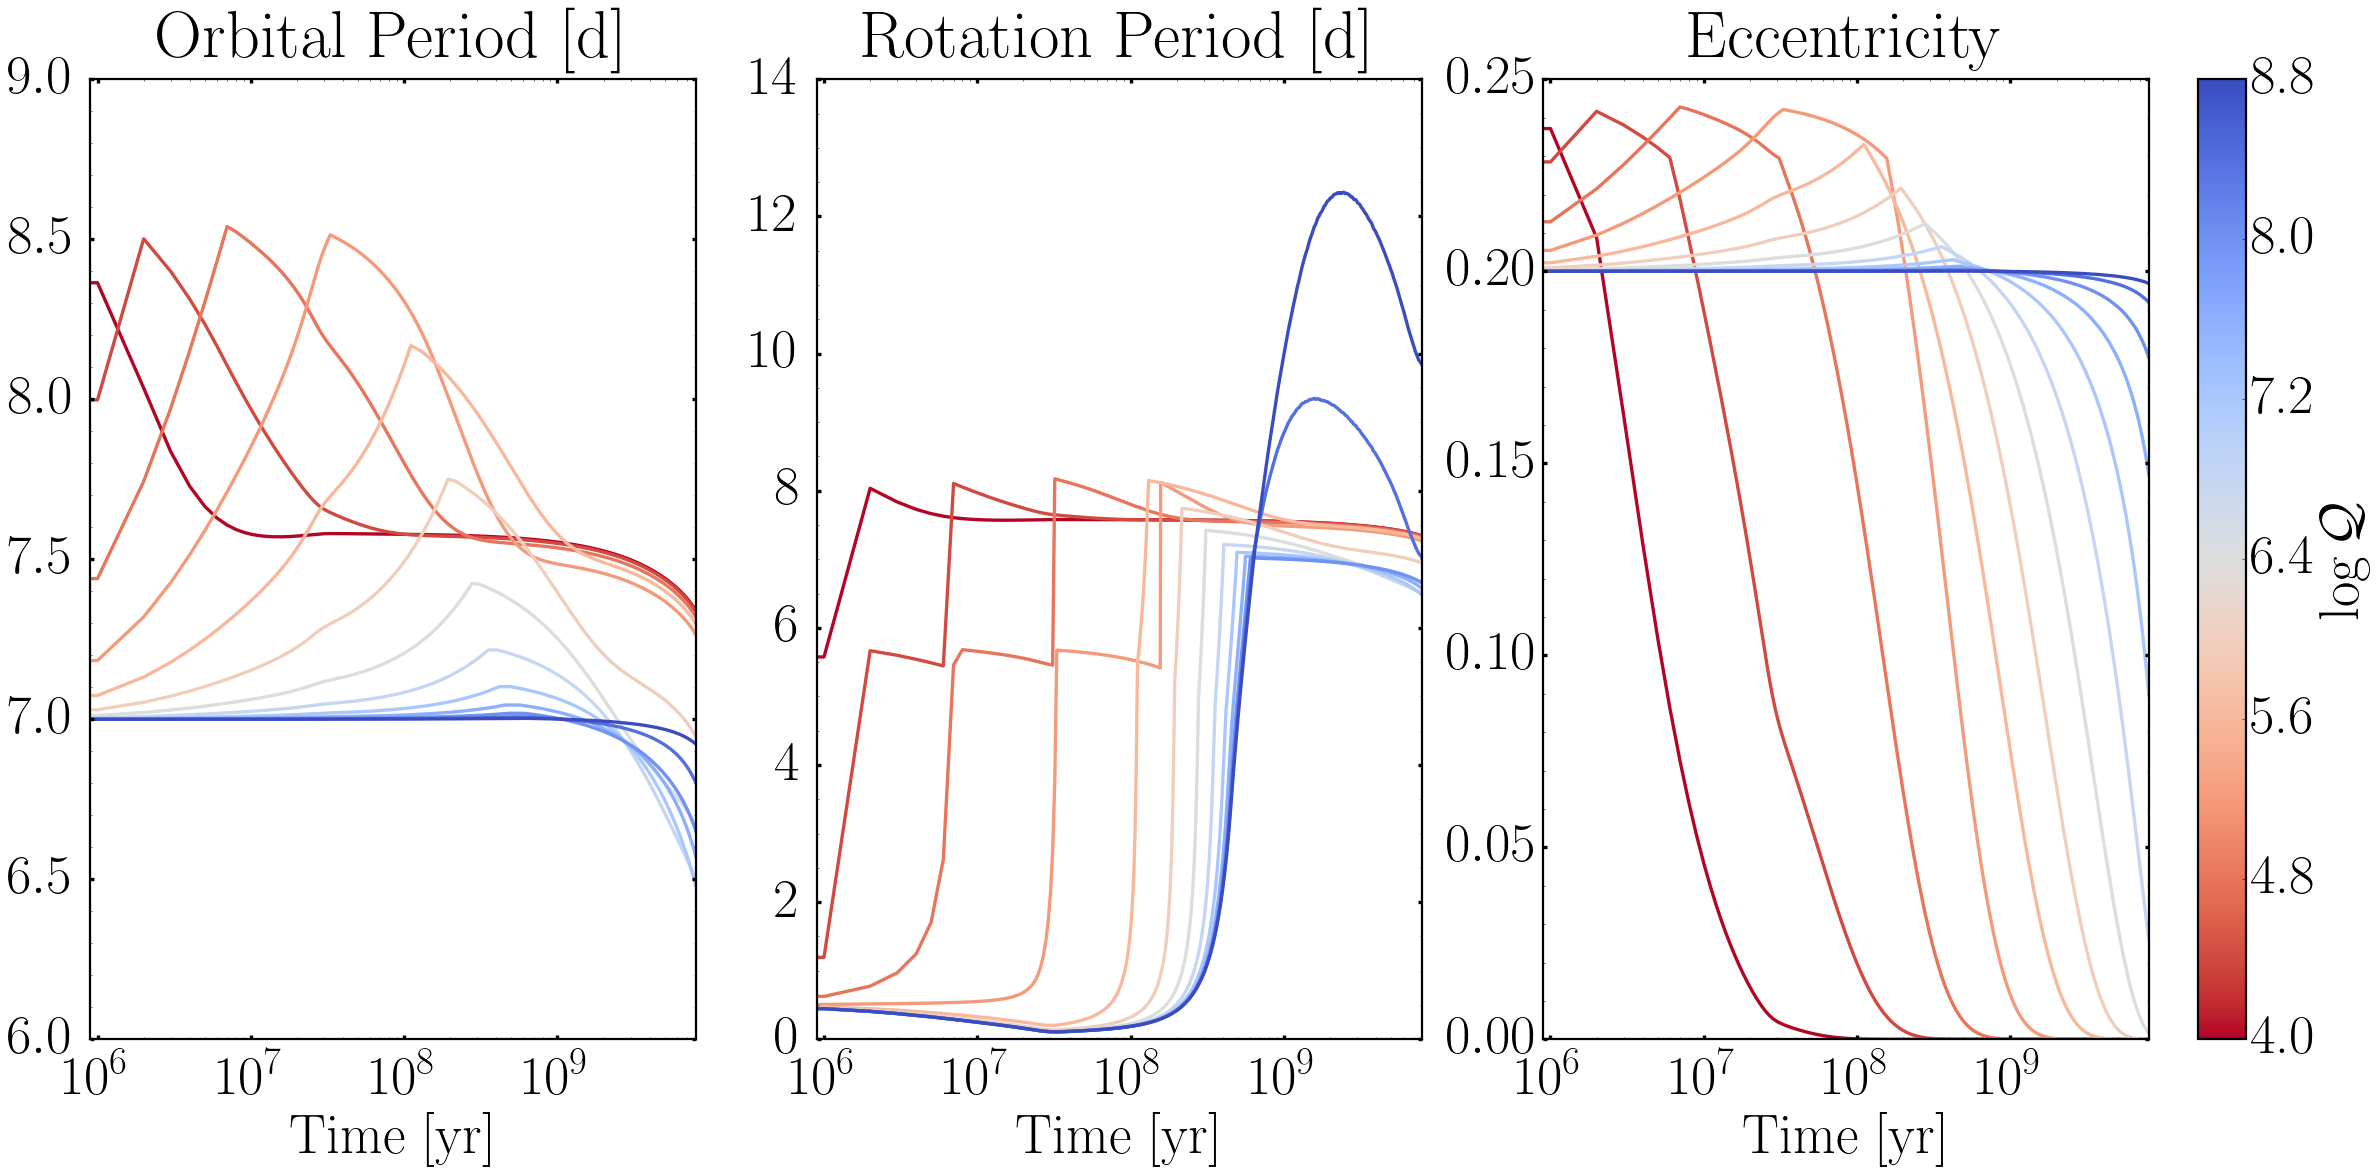

In [39]:
sims, qplot = cpl_evol, qvals
lw = 3
ls = 50
savename="/home/jbirky/Dropbox/Apps/Overleaf/Binary_Tides/figures/vary_q_evolution.png"
cb_label=r'$\log\mathcal{Q}$'
cmap=mpl.cm.coolwarm_r

results = [str(tv) for tv in qplot]
    
c = np.arange(0, len(sims))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cmap.set_array([])

fig, axs = plt.subplots(1, 3, figsize=[40,15], sharex=True)
fig.subplots_adjust(wspace=0.20)

for ii in range(len(results)):

    axs[0].plot(sims[ii]['Time'], sims[ii]['final.secondary.OrbPeriod'], lw=lw, c=cmap.to_rgba(ii))
    axs[1].plot(sims[ii]['Time'], sims[ii]['final.secondary.RotPer'], lw=lw, c=cmap.to_rgba(ii))
    im = axs[2].plot(sims[ii]['Time'], sims[ii]['final.secondary.Eccentricity'], lw=lw, c=cmap.to_rgba(ii))

plt.minorticks_on()
cb = fig.colorbar(cmap, ticks=c, ax=axs, orientation='vertical', pad=.02)
cb.set_label(cb_label, fontsize=ls)
cb.ax.set_yticklabels(qplot)
cb.set_ticks(c[::2])
cb.set_ticklabels(results[::2])

plt.xscale('log')
plt.xlim(9e5, 8e9)
axs[0].set_title("Orbital Period [d]", fontsize=ls+10, pad=20)
axs[1].set_title("Rotation Period [d]", fontsize=ls+10, pad=20)
axs[2].set_title("Eccentricity", fontsize=ls+10, pad=20)
axs[0].set_xlabel('Time [yr]', fontsize=ls)
axs[1].set_xlabel('Time [yr]', fontsize=ls)
axs[2].set_xlabel('Time [yr]', fontsize=ls)
axs[0].minorticks_on()
axs[1].minorticks_on()
axs[2].minorticks_on()
axs[0].xaxis.set_tick_params(width=3)
axs[0].yaxis.set_tick_params(width=3)
axs[1].xaxis.set_tick_params(width=3)
axs[1].yaxis.set_tick_params(width=3)
axs[2].xaxis.set_tick_params(width=3)
axs[2].yaxis.set_tick_params(width=3)
axs[0].tick_params(axis='both', which='major', pad=15)
axs[1].tick_params(axis='both', which='major', pad=15)
axs[2].tick_params(axis='y', which='major', pad=5)
axs[2].tick_params(axis='x', which='major', pad=15)
plt.savefig(savename, bbox_inches='tight', transparent=True)
plt.show()